In [395]:
import torch
from torch.optim import SGD, Adam
import torch.nn as nn


from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [396]:
INPUT_DIMENSION=40
OUTPUT_DIMENSION=1
NUMBER_OF_SAMPLES=10000
EPOCHS=20
LR=0.01

In [397]:
X,y=make_blobs(n_samples=1000, n_features=INPUT_DIMENSION, centers=2, random_state=1, cluster_std=1.5)

# Make the categories +/-1 rather thn 0,1
y=2*y-1 

# Transform the entries to have norm less than or equal to 1
X=X/max([np.linalg.norm(x) for x in X]) 

# Split data into train and test
(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.15)
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

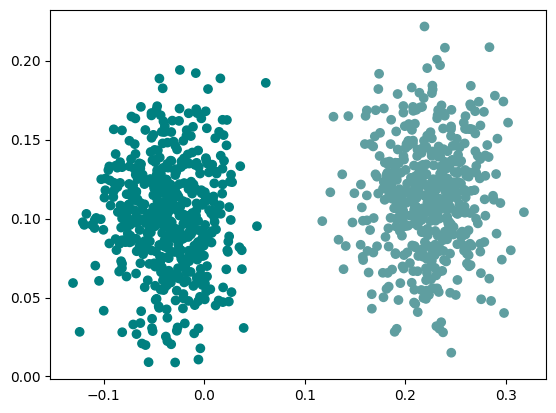

In [398]:
colors=np.full(len(y), 'cadetblue')
colors[y==-1]='teal'
plt.scatter(X[:,0],X[:,1],c=colors)

In [399]:
class LinearClassifier(torch.nn.Module):
  def __init__(self):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(in_features=INPUT_DIMENSION, out_features=OUTPUT_DIMENSION, bias=False)

  def forward(self, x):
    x = self.linear(x)
    return x

In [400]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [401]:
model=LinearClassifier()

In [402]:
model.linear.weight=torch.nn.Parameter(torch.from_numpy(np.random.random(INPUT_DIMENSION)).float())

In [403]:
# Train the model

opt = Adam(model.parameters(), lr=LR)
lossFunc = nn.L1Loss()

for epoch in range(0, EPOCHS):
	trainLoss = 0
	trainAcc = 0
	samples = 0
	model.train()
	for (batchX, batchY) in next_batch(trainX, trainY, 6):
		predictions = model(batchX)
		loss = lossFunc(predictions.view(-1), batchY)
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainLoss += loss.item() * len(batchY)
		trainAcc += (torch.sign(predictions) == batchY).sum().item()
		samples += len(batchY)
	print("Epoch: {} Train Loss: {:.3f} Train Accuracy: {:.3f}".format(epoch+1,trainLoss / samples,trainAcc / samples))

Epoch: 1 Train Loss: 0.235 Train Accuracy: 0.946
Epoch: 2 Train Loss: 0.091 Train Accuracy: 1.000
Epoch: 3 Train Loss: 0.078 Train Accuracy: 1.000
Epoch: 4 Train Loss: 0.068 Train Accuracy: 1.000
Epoch: 5 Train Loss: 0.060 Train Accuracy: 1.000
Epoch: 6 Train Loss: 0.053 Train Accuracy: 1.000
Epoch: 7 Train Loss: 0.049 Train Accuracy: 1.000
Epoch: 8 Train Loss: 0.046 Train Accuracy: 1.000
Epoch: 9 Train Loss: 0.046 Train Accuracy: 1.000
Epoch: 10 Train Loss: 0.045 Train Accuracy: 1.000
Epoch: 11 Train Loss: 0.044 Train Accuracy: 1.000
Epoch: 12 Train Loss: 0.044 Train Accuracy: 1.000
Epoch: 13 Train Loss: 0.045 Train Accuracy: 1.000
Epoch: 14 Train Loss: 0.045 Train Accuracy: 1.000
Epoch: 15 Train Loss: 0.044 Train Accuracy: 1.000
Epoch: 16 Train Loss: 0.043 Train Accuracy: 1.000
Epoch: 17 Train Loss: 0.044 Train Accuracy: 1.000
Epoch: 18 Train Loss: 0.043 Train Accuracy: 1.000
Epoch: 19 Train Loss: 0.043 Train Accuracy: 1.000
Epoch: 20 Train Loss: 0.043 Train Accuracy: 1.000


In [404]:
# Normalizing the decision vector

for param in model.parameters():
    decision_vector=param.tolist()
    decision_vector=decision_vector/np.linalg.norm(decision_vector)
model.linear.weight=torch.nn.Parameter(torch.from_numpy(decision_vector).float())

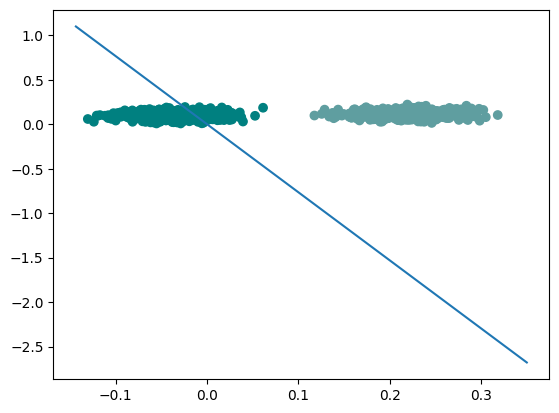

In [405]:
# Decision boundary projected onto first two coordinates

x=np.array([min(X[:,0])*1.1,max(X[:,0])*1.1])
grad=decision_vector[1]/decision_vector[0]
plt.plot(x,-x/grad)
plt.scatter(X[:,0],X[:,1],c=colors)

In [406]:
# Calculating the margin of the classifier

with torch.no_grad():
    for batchX, batchY in next_batch(testX, testY, len(testX)):
        predictions = model(batchX)
        margin=min(abs(predictions)).tolist()
print(margin)

0.5739438533782959


In [407]:
# Compressing the decision vector as per Algorithm 1

def algorithm_1(eta,c,gamma):
    c_hat=np.zeros(len(c))
    for k, comp in enumerate(c):
        p=2*comp**2/(eta*gamma**2)
        if np.random.random()<p:
            c_hat[k]=comp/p
    return c_hat

# Compressing the decision vector as per Algorithm 2

def algorithm_2(eta,c,gamma):
    k=16*np.log(1/eta)/(gamma**2)
    c_hat=np.zeros(len(c))
    for n in range(int(k)):
        vec=np.random.normal(loc=0,scale=1,size=len(c))
        c_hat+=np.dot(vec,c)*vec/k
    return c_hat, int(k)

Rate of compression: 55.0%


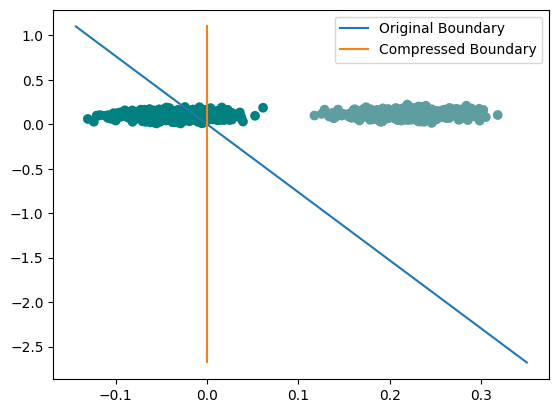

In [408]:
compressed_decision_vector_1=algorithm_1(0.25,decision_vector,margin)
#print('Original Classifier: {}'.format(decision_vector))
#print('Compressed Classifier: {}'.format(compressed_decision_vector_1))
print('Rate of compression: {}%'.format(100*sum(compressed_decision_vector_1==0)/len(decision_vector)))

# Compressed decision boundary projected onto first two coordinates

plt.plot(x,-x/grad,label='Original Boundary')
if compressed_decision_vector_1[0]!=0 and compressed_decision_vector_1[1]!=0:
    compressed_grad=compressed_decision_vector_1[1]/compressed_decision_vector_1[0]
    plt.plot(x,-x/compressed_grad,label='Compressed Boundary')
elif compressed_decision_vector_1[1]==0:
    plt.plot([0,0],[min(-x/grad),max(-x/grad)],label='Compressed Boundary')
else:
    plt.plot(x,-x*0,label='Compressed Boundary')
plt.scatter(X[:,0],X[:,1],c=colors)
plt.legend()

Rate of compression: -67.5%


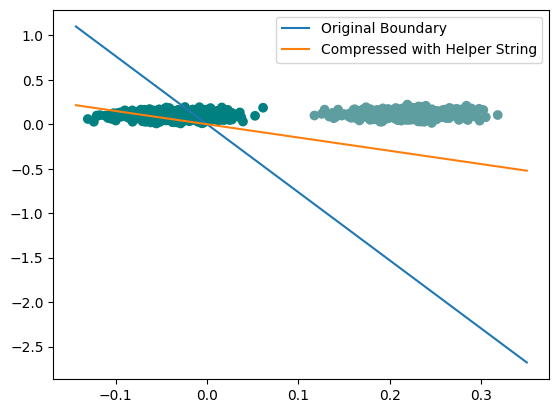

In [409]:
compressed_decision_vector_2, no_parameters=algorithm_2(0.25,decision_vector,margin)
#print('Original Classifier: {}'.format(decision_vector))
#print('Compressed Classifier: {}'.format(compressed_decision_vector_1))
print('Rate of compression: {}%'.format(100-100*no_parameters/len(decision_vector)))

# Compressed decision boundary projected onto first two coordinates

plt.plot(x,-x/grad,label='Original Boundary')
if compressed_decision_vector_2[0]!=0:
    compressed_grad=compressed_decision_vector_2[1]/compressed_decision_vector_2[0]
    plt.plot(x,-x/compressed_grad,label='Compressed with Helper String')
elif compressed_decision_vector_2[1]==0:
    plt.plot([0,0],[min(-x/grad),max(-x/grad)],label='Compressed Boundary')
else:
    plt.plot(x,-x*0,label='Compressed Boundary')
plt.scatter(X[:,0],X[:,1],c=colors)
plt.legend()

In [410]:
# Creating new models with compressed classifier

compressed_model=LinearClassifier()
compressed_model.linear.weight=torch.nn.Parameter(torch.from_numpy(compressed_decision_vector_1).float())

compressed_model_helper_string=LinearClassifier()
compressed_model_helper_string.linear.weight=torch.nn.Parameter(torch.from_numpy(compressed_decision_vector_2).float())

In [411]:
def accuracy_on_test(model):
    testAcc=0
    samples=0
    with torch.no_grad():
        for (batchX, batchY) in next_batch(testX, testY, 1):
            predictions = model(batchX)
            testAcc += (torch.sign(predictions) == batchY).sum().item()
            samples += batchY.size(0)
    return testAcc/samples

print('Original Model Test Error: {}\nCompressed Model Test Error: {}\nCompressed Model With Helper String Test Error: {}'.format(accuracy_on_test(model),accuracy_on_test(compressed_model),accuracy_on_test(compressed_model_helper_string)))

Original Model Test Error: 1.0
Compressed Model Test Error: 1.0
Compressed Model With Helper String Test Error: 1.0
